# Loading environment

In [87]:
import sys, getopt, os
import bonesis
import pandas as pd
from colomoto_jupyter import tabulate
import mpbn
import itertools
import math
import numpy
import networkx as nx
import pickle
#import ginsim
import re
import subprocess
import numpy as np
from matplotlib import pyplot as plt
from math import isnan
import clingo as asp
import mpbn
from copy import deepcopy 
sys.path.append('../py_src/')
import funForBonesis

# Loading binarized component activities for each HSPC states
These activities and their binariztation were computed on scRNA-seq data

In [88]:
geneOrder = ["Egr1","Junb","Bclaf1","Myc","Fli1","Gata2","Spi1","Cebpa","Gata1","Klf1","Tal1","Ikzf1","Zfpm1","CDK46CycD","CIPKIP"]

dataTable = pd.read_csv("../output/Inference/obsDataDis.csv",index_col = 0)

#Add some mutant obs

data = dataTable.to_dict("index")



clean_data = dict() #Bug of mpbn if nan in dict
for o in data.keys():
    clean_data[o] = {k: data[o][k] for k in data[o] if not isnan(data[o][k])}



obsData = pd.DataFrame.from_dict(data, orient="index").fillna('')[geneOrder]

obsData = obsData[geneOrder].reindex(["iHSC", "srHSC", "qHSC","preDiff","pLymph","pNeuMast","pMk","pEr","zero"])

obsData = obsData.transpose()
obsData.rename(columns = {'zero':'zeros'}, inplace = True)
obsData.rename(columns = {'CDK4/6CycD':'CDK46CycD'}, inplace = True)



obsData.index = ['Egr1', 'Junb', 'Bclaf1', 'Myc', 'Fli1', 'Gata2', 'Spi1', 'Cebpa',
       'Gata1', 'Klf1', 'Tal1', 'Ikzf1', 'Zfpm1', 'CDK46CycD', 'CIPKIP']
obsDataView = obsData.style.apply(lambda x: ["background: ligthgrey" if v == "" else  "background: darkred" if v == 1.0 else "background: darkblue" for v in x], axis = 1).apply(lambda x: ["color: lightgrey" if v == "" else  "color: darkred" if v == 1.0 else "color: darkblue" for v in x], axis = 1)


obsDataView.set_precision(0)

,iHSC,srHSC,qHSC,preDiff,pLymph,pNeuMast,pMk,pEr,zeros
Egr1,0,0,1,0,0,0,0,0,nan
Junb,0,0,1,0,0,0,0,0,nan
Bclaf1,1,1,0,1,1,0,0,0,nan
Myc,0,0,1,1,0,1,1,1,nan
Fli1,1,1,1,0,0,0,1,0,nan
Gata2,1,0,1,0,1,1,0,0,nan
Spi1,0,0,0,1,1,1,0,0,nan
Cebpa,0,0,0,0,0,1,0,0,nan
Gata1,0,0,0,0,0,0,1,1,nan
Klf1,0,0,0,0,0,0,0,1,nan


# Making some adjustement on the binarized data
Because no solution were obtained with the binarized data outputed from the scRNA-seq analysis, we made some adjustements for certain components in certain HSPC states. See our paper for more details. We also add the mutant binarized activities as well as the pME observation we observed in this analysis.

In [89]:
## Adjustement
dataTable["Myc"].loc["pNeuMast"] =  float('NaN')
dataTable["Myc"].loc["pEr"] =  float('NaN')
dataTable["Myc"].loc["pMk"] =  float('NaN')
dataTable["CDK46CycD"].loc["pMk"] =  float('NaN')
dataTable["Bclaf1"].loc["pLymph"] =  float('NaN')
dataTable["CIPKIP"].loc["pLymph"] =  float('NaN')

dataTable["Egr1"].loc["srHSC"] =  float('NaN')
dataTable["Gata2"].loc["pNeuMast"] =  float('NaN')



data = dataTable.to_dict("index")


clean_data = dict() #Bug of mpbn if nan in dict
for o in data.keys():
    clean_data[o] = {k: data[o][k] for k in data[o] if not isnan(data[o][k])}

data= clean_data
## add mutant obs
data["G0pMk"] = {'Junb': 1,
 'Tal1': 1.0,
 'Ikzf1': 0,
 'Spi1': 0,
 'Cebpa': 0,
 'Klf1': 0,
 'CIPKIP': 1,
 'CDK46CycD': 0.0}

data["G2MpNeuMast"] = {'Egr1': 0.0,
 'Junb': 0,
 'Tal1': 0.0,
 'Fli1': 0.0,
 'Ikzf1': 0,
 'Spi1': 1,
 'Cebpa': 1,
 'Klf1': 0,
 'Zfpm1': 0.0,
 'CIPKIP': 0,
 'CDK46CycD': 1.0}

data["pME"] = {'Egr1': 0.0,
 'Junb': 1,
 'Bclaf1': 1.0,
 'Myc': 1.0,
 'Fli1': 0,
 'Gata2': 0.0,
 'Spi1': 0,
 'Cebpa': 0,
 'Gata1': 0,
 'Klf1': 0,
 'CDK46CycD': 0.0,
 'CIPKIP': 0.0}

obsData = pd.DataFrame.from_dict(data, orient="index").fillna('')[geneOrder]

#Add some mutant obs

obsData = obsData[geneOrder].reindex(["iHSC", "srHSC", "qHSC","preDiff","pME","pLymph","pNeuMast","pMk","pEr","zero","G0pMk",'G2MpNeuMast'])


obsData = obsData.transpose()
obsData.index = ['Egr1', 'Junb', 'Bclaf1', 'Myc', 'Fli1', 'Gata2', 'Spi1', 'Cebpa',
       'Gata1', 'Klf1', 'Tal1', 'Ikzf1', 'Zfpm1', 'CDK46CycD', 'CIPKIP']
obsDataView = obsData.style.apply(lambda x: ["background: ligthgrey" if v == "" else  "background: darkred" if v == 1.0 else "background: darkblue" for v in x], axis = 1).apply(lambda x: ["color: lightgrey" if v == "" else  "color: darkred" if v == 1.0 else "color: darkblue" for v in x], axis = 1)


obsDataView.set_precision(0)

/home/leonard/bin/miniconda3/envs/bonesis_env/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,iHSC,srHSC,qHSC,preDiff,pME,pLymph,pNeuMast,pMk,pEr,zero,G0pMk,G2MpNeuMast
Egr1,0,,1,0,0,0,0,0,0,nan,,0
Junb,0,0,1,0,1,0,0,0,0,nan,1,0
Bclaf1,1,1,0,1,1,,0,0,0,nan,,
Myc,0,0,1,1,1,0,,,,nan,,
Fli1,1,1,1,0,0,0,0,1,0,nan,,0
Gata2,1,0,1,0,0,1,,0,0,nan,,
Spi1,0,0,0,1,0,1,1,0,0,nan,0,1
Cebpa,0,0,0,0,0,0,1,0,0,nan,0,1
Gata1,0,0,0,0,0,0,0,1,1,nan,,
Klf1,0,0,0,0,0,0,0,0,1,nan,0,0


# Loading set of Most Permissive Boolean Network (MPBN) that are solutions of our inference problem
Theses solution were obtained in the inference step described in the `../../scRNA_infer/output/Inference/bonesis/regulatory_graph_optimization.ipynb` notebook.

In [90]:
with open("../output/Inference/bonesis/possible_final_solutions.p", "rb") as input_file:
    solutions = pickle.load(input_file)

In [91]:
len(solutions)

616

In [92]:
table = pd.DataFrame(solutions)
table.sort_values(by=geneOrder, inplace=True)
table[geneOrder]

,Egr1,Junb,Bclaf1,Myc,Fli1,Gata2,Spi1,Cebpa,Gata1,Klf1,Tal1,Ikzf1,Zfpm1,CDK46CycD,CIPKIP
105,Gata2&Junb,Egr1|Myc,Myc,Bclaf1&Cebpa,Junb|(Gata1&!Klf1),(!Gata1&Egr1)|(!Gata1&Gata2)|(!Spi1&Gata2&!Zfpm1),(!Gata1&Spi1)|(!Gata1&!Gata2&Cebpa),(!Ikzf1&Gata2)|(!Ikzf1&Spi1),Fli1|(Gata1&!Ikzf1)|(!Spi1&Gata2),Gata1&!Fli1,Gata1&!Spi1,Gata2,Gata1,Myc&Bclaf1,Junb
362,Gata2&Junb,Egr1|Myc,Myc,Bclaf1&Cebpa,Junb|(Gata1&!Klf1),(!Gata1&Egr1)|(!Gata1&Gata2)|(!Spi1&Gata2&!Zfpm1),(!Gata1&Spi1)|(!Gata1&!Gata2&Cebpa),(!Ikzf1&Gata2)|(!Ikzf1&Spi1),Fli1|(Gata1&!Ikzf1)|(!Spi1&Gata2),Gata1&!Fli1,Gata1&!Spi1,Gata2,Gata1,Bclaf1|Myc,Junb
25,Gata2&Junb,Egr1|Myc,Myc,Bclaf1&Cebpa,Junb|(Gata1&!Klf1),(!Gata1&Egr1)|(!Gata1&Gata2)|(!Spi1&Gata2&!Zfpm1),(!Gata1&Spi1)|(!Gata1&!Gata2&Cebpa),(!Ikzf1&Gata2)|(!Ikzf1&Spi1),Fli1|(!Spi1&Gata2)|(Gata1&!Spi1&!Ikzf1),Gata1&!Fli1,Gata1&!Spi1,Gata2,Gata1,Myc&Bclaf1,Junb
154,Gata2&Junb,Egr1|Myc,Myc,Bclaf1&Cebpa,Junb|(Gata1&!Klf1),(!Gata1&Egr1)|(!Gata1&Gata2)|(!Spi1&Gata2&!Zfpm1),(!Gata1&Spi1)|(!Gata1&!Gata2&Cebpa),(!Ikzf1&Gata2)|(!Ikzf1&Spi1),Fli1|(!Spi1&Gata2)|(Gata1&!Spi1&!Ikzf1),Gata1&!Fli1,Gata1&!Spi1,Gata2,Gata1,Bclaf1|Myc,Junb
196,Gata2&Junb,Egr1|Myc,Myc,Bclaf1&Cebpa,Junb|(Gata1&!Klf1),(!Gata1&Egr1)|(!Gata1&Gata2)|(!Zfpm1&!Spi1&Egr1),(!Gata1&Spi1)|(!Gata1&!Gata2&Cebpa),(!Ikzf1&Gata2)|(!Ikzf1&Spi1),Fli1|(Gata1&!Ikzf1)|(!Spi1&Gata2),Gata1&!Fli1,Gata1&!Spi1,Gata2,Gata1,Myc&Bclaf1,Junb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,Gata2&Junb,Egr1|Myc,Myc,Bclaf1&Cebpa,(Gata1&Junb)|(Gata1&!Klf1)|(!Klf1&Junb),(!Zfpm1&!Spi1&Egr1)|(!Gata1&Gata2&!Zfpm1)|(!Sp...,(!Gata1&Spi1)|(!Gata1&!Gata2&Cebpa),(!Ikzf1&Gata2)|(!Ikzf1&Spi1),Fli1|(!Spi1&Gata2)|(Gata1&!Spi1&!Ikzf1),Gata1&!Fli1,Gata1&!Spi1,Gata2,Gata1,Bclaf1|Myc,Junb
451,Gata2&Junb,Egr1|Myc,Myc,Bclaf1&Cebpa,(Gata1&Junb)|(Gata1&!Klf1)|(!Klf1&Junb),(!Zfpm1&!Spi1&Egr1)|(!Gata1&!Spi1&Gata2)|(!Gat...,(!Gata1&Spi1)|(!Gata1&!Gata2&Cebpa),(!Ikzf1&Gata2)|(!Ikzf1&Spi1),Fli1|(Gata1&!Ikzf1)|(!Spi1&Gata2),Gata1&!Fli1,Gata1&!Spi1,Gata2,Gata1,Myc&Bclaf1,Junb
71,Gata2&Junb,Egr1|Myc,Myc,Bclaf1&Cebpa,(Gata1&Junb)|(Gata1&!Klf1)|(!Klf1&Junb),(!Zfpm1&!Spi1&Egr1)|(!Gata1&!Spi1&Gata2)|(!Gat...,(!Gata1&Spi1)|(!Gata1&!Gata2&Cebpa),(!Ikzf1&Gata2)|(!Ikzf1&Spi1),Fli1|(Gata1&!Ikzf1)|(!Spi1&Gata2),Gata1&!Fli1,Gata1&!Spi1,Gata2,Gata1,Bclaf1|Myc,Junb
179,Gata2&Junb,Egr1|Myc,Myc,Bclaf1&Cebpa,(Gata1&Junb)|(Gata1&!Klf1)|(!Klf1&Junb),(!Zfpm1&!Spi1&Egr1)|(!Gata1&!Spi1&Gata2)|(!Gat...,(!Gata1&Spi1)|(!Gata1&!Gata2&Cebpa),(!Ikzf1&Gata2)|(!Ikzf1&Spi1),Fli1|(!Spi1&Gata2)|(Gata1&!Spi1&!Ikzf1),Gata1&!Fli1,Gata1&!Spi1,Gata2,Gata1,Myc&Bclaf1,Junb


We can print the number of possible rules for each component of the network.

In [93]:
table.nunique()

Bclaf1        1
CDK46CycD     2
CIPKIP        1
Cebpa         1
Egr1          1
Fli1          2
Gata1         2
Gata2        77
Ikzf1         1
Junb          1
Klf1          1
Myc           1
Spi1          1
Tal1          1
Zfpm1         1
dtype: int64

We can print the possible rule for each component having more than one possible rule.

In [94]:
for n in table.nunique().index:
    if table.nunique()[n] > 1:
        print(n)
        print(pd.DataFrame(table[n].unique())) 


CDK46CycD
            0
0  Myc&Bclaf1
1  Bclaf1|Myc
Fli1
                                         0
0                       Junb|(Gata1&!Klf1)
1  (Gata1&Junb)|(Gata1&!Klf1)|(!Klf1&Junb)
Gata1
                                         0
0        Fli1|(Gata1&!Ikzf1)|(!Spi1&Gata2)
1  Fli1|(!Spi1&Gata2)|(Gata1&!Spi1&!Ikzf1)
Gata2
                                                    0
0   (!Gata1&Egr1)|(!Gata1&Gata2)|(!Spi1&Gata2&!Zfpm1)
1    (!Gata1&Egr1)|(!Gata1&Gata2)|(!Zfpm1&!Spi1&Egr1)
2   (!Gata1&Egr1)|(!Gata1&Gata2)|(!Zfpm1&!Spi1&Gat...
3   (!Gata1&Egr1)|(!Gata1&Gata2&!Zfpm1)|(!Spi1&Gat...
4   (!Gata1&Egr1)|(!Gata1&Gata2&!Zfpm1)|(!Zfpm1&!S...
..                                                ...
72  (!Zfpm1&Gata2&Egr1)|(!Zfpm1&!Spi1&Egr1)|(!Gata...
73          (!Zfpm1&!Spi1&Egr1)|(!Gata1&Gata2&!Zfpm1)
74  (!Zfpm1&!Spi1&Egr1)|(!Gata1&Gata2&!Zfpm1)|(!Ga...
75  (!Zfpm1&!Spi1&Egr1)|(!Gata1&Gata2&!Zfpm1)|(!Sp...
76  (!Zfpm1&!Spi1&Egr1)|(!Gata1&!Spi1&Gata2)|(!Gat...

[77 rows x 1 columns]


We save the possible rules for Gata2 in csv table.

In [95]:
pd.DataFrame(table["Gata2"].unique()).to_csv("tables/Gata2_rules.csv")

Based on literature evidences and favoring simpler (small number of clauses) rules we select one rule for each of these components.

In [96]:
keptRules = mpbn.MPBooleanNetwork({
    "Fli1":"Junb|(Gata1&!Klf1)",
    "Gata2": "(!Gata1&Gata2&!Zfpm1)|(!Spi1&Egr1&!Zfpm1&!Gata1)",
    "CDK46CycD": "Myc|Bclaf1",
    "Gata1":"Fli1|(!Spi1&Gata2)|(!Spi1&!Ikzf1&Gata1)"})
keptRules

CDK46CycD <- Myc|Bclaf1
Fli1 <- Junb|(Gata1&!Klf1)
Gata1 <- Fli1|(!Spi1&Gata2)|(!Spi1&!Ikzf1&Gata1)
Gata2 <- (!Gata1&Gata2&!Zfpm1)|(!Spi1&Egr1&!Zfpm1&!Gata1)

In [97]:
tableFinal = table.copy()
for n in keptRules.keys():
    if table.nunique()[n] > 1:
        tableFinal = tableFinal[(tableFinal[n] == keptRules[n])]

We make sure that we kept one model from the set of possible solutions.

In [98]:
tableFinal


,Bclaf1,CDK46CycD,CIPKIP,Cebpa,Egr1,Fli1,Gata1,Gata2,Ikzf1,Junb,Klf1,Myc,Spi1,Tal1,Zfpm1
206,Myc,Bclaf1|Myc,Junb,(!Ikzf1&Gata2)|(!Ikzf1&Spi1),Gata2&Junb,Junb|(Gata1&!Klf1),Fli1|(!Spi1&Gata2)|(Gata1&!Spi1&!Ikzf1),(!Gata1&Gata2&!Zfpm1)|(!Gata1&!Zfpm1&!Spi1&Egr1),Gata2,Egr1|Myc,Gata1&!Fli1,Bclaf1&Cebpa,(!Gata1&Spi1)|(!Gata1&!Gata2&Cebpa),Gata1&!Spi1,Gata1


In [99]:
solutionFinal = solutions[tableFinal.index[0]] #### result order should be stable with the sorting
print(solutionFinal)

Bclaf1 <- Myc
CDK46CycD <- Bclaf1|Myc
CIPKIP <- Junb
Cebpa <- (!Ikzf1&Gata2)|(!Ikzf1&Spi1)
Egr1 <- Gata2&Junb
Fli1 <- Junb|(Gata1&!Klf1)
Gata1 <- Fli1|(!Spi1&Gata2)|(Gata1&!Spi1&!Ikzf1)
Gata2 <- (!Gata1&Gata2&!Zfpm1)|(!Gata1&!Zfpm1&!Spi1&Egr1)
Ikzf1 <- Gata2
Junb <- Egr1|Myc
Klf1 <- Gata1&!Fli1
Myc <- Bclaf1&Cebpa
Spi1 <- (!Gata1&Spi1)|(!Gata1&!Gata2&Cebpa)
Tal1 <- Gata1&!Spi1
Zfpm1 <- Gata1



In [100]:
#solGisSim = solutionFinal.copy()
#solGisSim["CDK46CycD"] = solGisSim.pop("CDK46CycD")
#solGisSim = solGisSim.to_biolqm()
#solGisSim = biolqm.to_ginsim(solGisSim)
#solGisSim.save('solutionFinal.zginml')

# Saving rules of final model

In [101]:
tableFinal[geneOrder].transpose()
tableFinal[geneOrder].transpose().to_csv("tables/final_Boolean_model.csv")

# Saving interaction table
We update the interaction table by indicating whether it is part of the final selected model or not and save the result.

In [102]:
influenceGraphTable = pd.read_table("../output/Inference/influenceGraph/infGraphTable45.tsv")
influenceGraphTable = influenceGraphTable.drop_duplicates(subset=['tf', 'target', 'mor'])
# Creating influence graph 
inf0 = []
for r in influenceGraphTable.index:
    inf0.append((influenceGraphTable["tf"][r],influenceGraphTable["target"][r],dict(sign= influenceGraphTable["mor"][r])))

allEdges = funForBonesis.multiDiGraphToEdgeList(solutionFinal.influence_graph())

influenceGraphTable["solution"] = [True if inf0[e] in allEdges else False for e in range(len(inf0))]
influenceGraphTable[influenceGraphTable["solution"]].to_csv("tables/interactionTableFinalSol.csv")
influenceGraphTable[influenceGraphTable["solution"]]


,tf,mor,target,ref,interaction_proof_level,cell_line,cell_type_tissue,Trusted,Scenic,cistromeAdjScore,interaction0,solution
0,Bclaf1,1,CDK46CycD,NaN,NaN,NaN,NaN,0,True,NaN,Bclaf1_CDK46CycD,True
2,Bclaf1,1,Myc,NaN,NaN,NaN,NaN,0,True,NaN,Bclaf1_Myc,True
5,Cebpa,1,Myc,NaN,NaN,NaN,NaN,0,True,2.982833,Cebpa_Myc,True
6,Egr1,1,Junb,NaN,NaN,NaN,NaN,0,True,0.007750,Egr1_Junb,True
8,Egr1,1,Gata2,NaN,NaN,NaN,NaN,0,True,0.000000,Egr1_Gata2,True
12,Gata1,1,Klf1,Crossley_1994;Krumsiek_2011,transcriptionnal regulation,MEL,NaN,1,True,3.243200,Gata1_Klf1,True
13,Gata1,1,Gata1,Tsai_1991;Krumsiek_2011,transcriptionnal_regulation,MEL,NaN,1,True,2.538600,Gata1_Gata1,True
14,Gata2,1,Ikzf1,Malinge_2013,transcriptionnal regulation,G1ME,NaN,1,True,0.370300,Gata2_Ikzf1,True
17,Gata2,1,Cebpa,Cooper_2015,transcriptionnal regulation (+37 kb enhancer b...,NaN,32Dcl3,0,True,0.010200,Gata2_Cebpa,True
18,Gata2,1,Egr1,NaN,NaN,NaN,NaN,0,True,0.108300,Gata2_Egr1,True


# Drawing of the influence graph of the final solution

# computing graph layout...


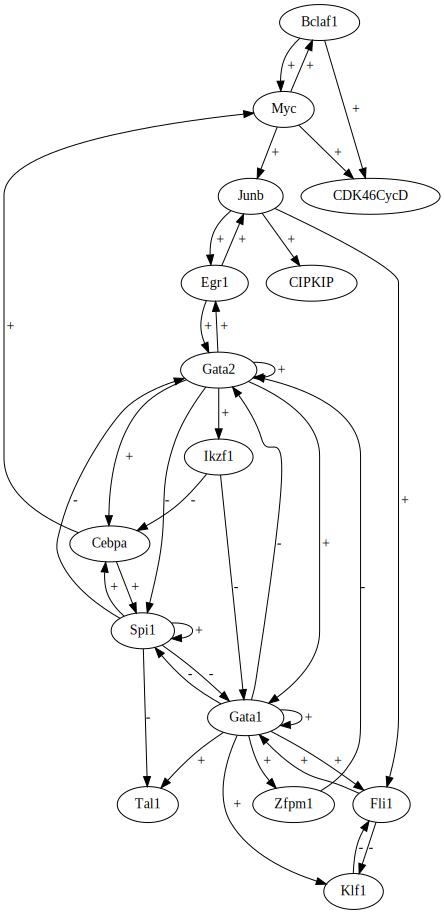

In [103]:
solutionFinal.influence_graph()

## Analysis of the dynamics of the model
We make some analyses of the model dynamics in normal and perturbed condition in th MP semantic with the` mpbn` package.

Print all attractors reachable from iHSC in normal condition.

In [104]:

att = pd.DataFrame(solutionFinal.attractors(reachable_from=data["iHSC"]))
att


,Bclaf1,CDK46CycD,CIPKIP,Cebpa,Egr1,Fli1,Gata1,Gata2,Ikzf1,Junb,Klf1,Myc,Spi1,Tal1,Zfpm1
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1
4,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1


In [105]:
att.index = ["zero","pLymph","pNeuMast","pMk","pEr"]
att = att[geneOrder].transpose()
attView = att.style.apply(lambda x: ["background: ligthgrey" if v == "" else  "background: darkred" if v == 1.0 else "background: darkblue" for v in x], axis = 1).apply(lambda x: ["color: lightgrey" if v == "" else  "color: darkred" if v == 1.0 else "color: darkblue" for v in x], axis = 1)

attView.set_precision(0)

,zero,pLymph,pNeuMast,pMk,pEr
Egr1,0,0,0,0,0
Junb,0,0,0,0,0
Bclaf1,0,0,0,0,0
Myc,0,0,0,0,0
Fli1,0,0,0,1,0
Gata2,0,1,0,0,0
Spi1,0,1,1,0,0
Cebpa,0,0,1,0,0
Gata1,0,0,0,1,1
Klf1,0,0,0,0,1


Print all attractors reachable from qHSC in normal condition.

In [106]:
pd.DataFrame(solutionFinal.attractors(reachable_from=data["qHSC"]))


,Bclaf1,CDK46CycD,CIPKIP,Cebpa,Egr1,Fli1,Gata1,Gata2,Ikzf1,Junb,Klf1,Myc,Spi1,Tal1,Zfpm1
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1
4,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1


Print all attractors reachable from qHSC in normal condition.

In [107]:
pd.DataFrame(solutionFinal.attractors(reachable_from=data["srHSC"]))

,Bclaf1,CDK46CycD,CIPKIP,Cebpa,Egr1,Fli1,Gata1,Gata2,Ikzf1,Junb,Klf1,Myc,Spi1,Tal1,Zfpm1
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1
4,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1


Is prediff reachable from qHSC in normal condition?

In [108]:
print(solutionFinal.reachability(data["qHSC"],data["preDiff"]))


True


Drawing table of figure 3 of our paper with the model metaconfigurations considrered in our analysis the dynamics.

In [109]:
obsDataFin = pd.concat([obsData[["iHSC", "srHSC", "qHSC","preDiff","pME"]], att], axis=1)
obsDataFin["srHSC"]["Egr1"] = 1


obsDataFin.rename(columns = {'zero':'zeros'}, inplace = True)

obsDataFin.index = ['Egr1', 'Junb', 'Bclaf1', 'Myc', 'Fli1', 'Gata2', 'Spi1', 'Cebpa',
       'Gata1', 'Klf1', 'Tal1', 'Ikzf1', 'Zfpm1', 'CDK46CycD', 'CIPKIP']
obsDataFinView = obsDataFin.style.apply(lambda x: ["background: ligthgrey" if v == "" else  "background: darkred" if v == 1.0 else "background: darkblue" for v in x], axis = 1).apply(lambda x: ["color: lightgrey" if v == "" else  "color: darkred" if v == 1.0 else "color: darkblue" for v in x], axis = 1)



obsDataFinView.set_precision(0)

/home/leonard/bin/miniconda3/envs/bonesis_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,iHSC,srHSC,qHSC,preDiff,pME,zeros,pLymph,pNeuMast,pMk,pEr
Egr1,0,1,1,0,0,0,0,0,0,0
Junb,0,0,1,0,1,0,0,0,0,0
Bclaf1,1,1,0,1,1,0,0,0,0,0
Myc,0,0,1,1,1,0,0,0,0,0
Fli1,1,1,1,0,0,0,0,0,1,0
Gata2,1,0,1,0,0,0,1,0,0,0
Spi1,0,0,0,1,0,0,1,1,0,0
Cebpa,0,0,0,0,0,0,0,1,0,0
Gata1,0,0,0,0,0,0,0,0,1,1
Klf1,0,0,0,0,0,0,0,0,0,1


## Some Egr1 KO mutant analysis

In [110]:
data["srHSC_Egr1_0"] = deepcopy(data["srHSC"])
data["srHSC_Egr1_0"]["Egr1"] = 0
data

{'iHSC': {'Egr1': 0.0,
  'Junb': 0,
  'Bclaf1': 1.0,
  'Myc': 0.0,
  'Fli1': 1,
  'Gata2': 1.0,
  'Spi1': 0,
  'Cebpa': 0,
  'Gata1': 0,
  'Klf1': 0,
  'Tal1': 1.0,
  'Ikzf1': 0.0,
  'CDK46CycD': 0.0,
  'CIPKIP': 0.0},
 'srHSC': {'Junb': 0,
  'Bclaf1': 1.0,
  'Myc': 0.0,
  'Fli1': 1,
  'Gata2': 0.0,
  'Spi1': 0,
  'Cebpa': 0,
  'Gata1': 0,
  'Klf1': 0,
  'CDK46CycD': 1.0,
  'CIPKIP': 0.0},
 'qHSC': {'Egr1': 1.0,
  'Junb': 1,
  'Bclaf1': 0.0,
  'Myc': 1.0,
  'Fli1': 1,
  'Gata2': 1.0,
  'Spi1': 0,
  'Cebpa': 0,
  'Gata1': 0,
  'Klf1': 0,
  'Tal1': 1.0,
  'Ikzf1': 0.0,
  'CDK46CycD': 1.0,
  'CIPKIP': 1.0},
 'preDiff': {'Egr1': 0.0,
  'Junb': 0,
  'Bclaf1': 1.0,
  'Myc': 1.0,
  'Fli1': 0,
  'Gata2': 0.0,
  'Spi1': 1,
  'Cebpa': 0,
  'Gata1': 0,
  'Klf1': 0,
  'CDK46CycD': 0.0,
  'CIPKIP': 0.0},
 'pLymph': {'Egr1': 0.0,
  'Junb': 0,
  'Myc': 0.0,
  'Fli1': 0,
  'Gata2': 1.0,
  'Spi1': 1,
  'Cebpa': 0,
  'Gata1': 0,
  'Klf1': 0,
  'Tal1': 0.0,
  'Ikzf1': 1.0,
  'CDK46CycD': 0.0},
 'pNeuMast

In [111]:
print(solutionFinal.reachability(data["iHSC"],data["srHSC"]))
print(solutionFinal.reachability(data["srHSC"],data["iHSC"]))
print(solutionFinal.reachability(data["iHSC"],data["srHSC_Egr1_0"]))
print(solutionFinal.reachability(data["srHSC_Egr1_0"],data["iHSC"]))

True
True
True
False


## Analysis of a preDiffCyc metaconfiguration

In [112]:
 data["preDiffCyc"] ={'Egr1': 0.0,
 'Junb': 0,
 'Bclaf1': 1.0,
 'Myc': 1.0,
 'Fli1': 0,
 'Spi1': 1,
 'Cebpa': 0,
 'Gata1': 0,
 'Klf1': 0,
 'CDK46CycD': 1,
 'CIPKIP': 0.0}

In [113]:
print(solutionFinal.reachability(data["iHSC"],data["preDiffCyc"]))
print(solutionFinal.reachability(data["preDiffCyc"],data["preDiff"]))
print(solutionFinal.reachability(data["preDiff"],data["preDiffCyc"]))
pd.DataFrame(solutionFinal.attractors(reachable_from=data["preDiffCyc"]))

True
True
True


,Bclaf1,CDK46CycD,CIPKIP,Cebpa,Egr1,Fli1,Gata1,Gata2,Ikzf1,Junb,Klf1,Myc,Spi1,Tal1,Zfpm1
0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1
4,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1


Is the deactivation of Gata2 reversible from preDiff?

In [114]:
data["Gata2+"]={'Gata2': 1}
print(solutionFinal.reachability(data["preDiff"],data["Gata2+"]))

False


## Analysis of the pME branching metaconfiguration

In [115]:
data["pME"] = {'Egr1': 0.0,
 'Junb': 1,
 'Bclaf1': 1.0,
 'Myc': 1.0,
 'Fli1': 0,
 'Gata2': 0.0,
 'Spi1': 0,
 'Cebpa': 0,
 'Gata1': 0,
 'Klf1': 0,
 'CDK46CycD': 0.0,
 'CIPKIP': 0.0}

data["preDiff"]["Ikzf1"]=0
print(solutionFinal.reachability(data["preDiff"],data["pME"]))
print(solutionFinal.reachability(data["pME"],data["pNeuMast"]))
print(solutionFinal.reachability(data["pME"],data["pEr"]))
print(solutionFinal.reachability(data["pME"],data["pMk"]))
print(solutionFinal.reachability(data["pME"],data["preDiff"]))





True
False
True
True
False


In [116]:
pd.DataFrame(solutionFinal.attractors(reachable_from=data["pME"]))

,Bclaf1,CDK46CycD,CIPKIP,Cebpa,Egr1,Fli1,Gata1,Gata2,Ikzf1,Junb,Klf1,Myc,Spi1,Tal1,Zfpm1
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1
2,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1


## Analysis of the influence of Zfpm1 activity level at initial state

In [117]:
data["iHSC_Zfpm1_1"] = {'Egr1': 0.0,
 'Junb': 0,
 'Bclaf1': 1.0,
 'Myc': 0.0,
 'Fli1': 1,
 'Gata2': 1.0,
 'Spi1': 0,
 'Cebpa': 0,
 'Gata1': 0,
 'Klf1': 0,
 'Tal1': 1.0,
 'Ikzf1': 0.0,
  'Zfpm1':1,
 'CDK46CycD': 0.0,
 'CIPKIP': 0.0}
print(solutionFinal.reachability(data["iHSC_Zfpm1_1"],data["srHSC"]))
print(solutionFinal.reachability(data["iHSC_Zfpm1_1"],data["qHSC"]))
pd.DataFrame(solutionFinal.attractors(reachable_from=data["iHSC_Zfpm1_1"]))



True
True


,Bclaf1,CDK46CycD,CIPKIP,Cebpa,Egr1,Fli1,Gata1,Gata2,Ikzf1,Junb,Klf1,Myc,Spi1,Tal1,Zfpm1
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1
4,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1


In [118]:
data["iHSC_Zfpm1_0"] = {'Egr1': 0.0,
 'Junb': 0,
 'Bclaf1': 1.0,
 'Myc': 0.0,
 'Fli1': 1,
 'Gata2': 1.0,
 'Spi1': 0,
 'Cebpa': 0,
 'Gata1': 0,
 'Klf1': 0,
 'Tal1': 1.0,
 'Ikzf1': 0.0,
  'Zfpm1':0,
 'CDK46CycD': 0.0,
 'CIPKIP': 0.0}

print(solutionFinal.reachability(data["iHSC_Zfpm1_0"],data["srHSC"]))
print(solutionFinal.reachability(data["iHSC_Zfpm1_0"],data["qHSC"]))
pd.DataFrame(solutionFinal.attractors(reachable_from=data["iHSC_Zfpm1_0"]))

True
True


,Bclaf1,CDK46CycD,CIPKIP,Cebpa,Egr1,Fli1,Gata1,Gata2,Ikzf1,Junb,Klf1,Myc,Spi1,Tal1,Zfpm1
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1
4,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1


# Test model alteration

In [119]:
def testPerturb(model,perturbations,data,start=None):
    data_mut = deepcopy(data)

    if start is not None:
        data_mut["iHSC"] = start
        
    test_mut = model.copy()
    for perturbation in perturbations:
        del test_mut[[*perturbation.keys()][0]]
        test_mut[[*perturbation.keys()][0]] = [*perturbation.values()][0]
        if ([*perturbation.values()][0] == 1) | ([*perturbation.values()][0] == 0):
            data_mut["iHSC"][[*perturbation.keys()][0]] = [*perturbation.values()][0]
            data_mut["qHSC"][[*perturbation.keys()][0]] = [*perturbation.values()][0]
            data_mut["srHSC"][[*perturbation.keys()][0]] = [*perturbation.values()][0]
            data_mut["preDiff"][[*perturbation.keys()][0]] = [*perturbation.values()][0]

    
    print(data_mut["qHSC"])
    print(data_mut["srHSC"])
    print(data_mut["preDiff"])
    att = pd.DataFrame(test_mut.attractors())[geneOrder]
    print("attractors from qHSC")
    print(pd.DataFrame(test_mut.attractors(reachable_from=data_mut["qHSC"]))[geneOrder])
    print("attractors from srHSC")
    print(pd.DataFrame(test_mut.attractors(reachable_from=data_mut["srHSC"]))[geneOrder])
    print("attractors from iHSC")
    print(pd.DataFrame(test_mut.attractors(reachable_from=data_mut["iHSC"]))[geneOrder])
    print("reachability of preDiff state from iHSC:")
    print(test_mut.reachability(data_mut["iHSC"],data_mut["preDiff"]))
    print("reachability of preDiff state from srHSC:")
    print(test_mut.reachability(data_mut["srHSC"],data_mut["preDiff"]))
    print("reachability of preDiff state from qHSC:")
    print(test_mut.reachability(data_mut["qHSC"],data_mut["preDiff"]))
    print("reachability of iHSC from qHSC:")
    print(test_mut.reachability(data_mut["qHSC"],data_mut["iHSC"]))
    print("reachability of srHSC from qHSC:")
    print(test_mut.reachability(data_mut["qHSC"],data_mut["srHSC"]))

    return att

## Test KO mutation

### constrained alterations

In [120]:
testPerturb(solutionFinal,[{"Klf1":0}],data)

{'Egr1': 1.0, 'Junb': 1, 'Bclaf1': 0.0, 'Myc': 1.0, 'Fli1': 1, 'Gata2': 1.0, 'Spi1': 0, 'Cebpa': 0, 'Gata1': 0, 'Klf1': 0, 'Tal1': 1.0, 'Ikzf1': 0.0, 'CDK46CycD': 1.0, 'CIPKIP': 1.0}
{'Junb': 0, 'Bclaf1': 1.0, 'Myc': 0.0, 'Fli1': 1, 'Gata2': 0.0, 'Spi1': 0, 'Cebpa': 0, 'Gata1': 0, 'Klf1': 0, 'CDK46CycD': 1.0, 'CIPKIP': 0.0}
{'Egr1': 0.0, 'Junb': 0, 'Bclaf1': 1.0, 'Myc': 1.0, 'Fli1': 0, 'Gata2': 0.0, 'Spi1': 1, 'Cebpa': 0, 'Gata1': 0, 'Klf1': 0, 'CDK46CycD': 0.0, 'CIPKIP': 0.0, 'Ikzf1': 0}
attractors from qHSC
   Egr1  Junb  Bclaf1  Myc  Fli1  Gata2  Spi1  Cebpa  Gata1  Klf1  Tal1  \
0     0     0       0    0     0      0     0      0      0     0     0   
1     0     0       0    0     0      1     1      0      0     0     0   
2     0     0       0    0     0      0     1      1      0     0     0   
3     0     0       0    0     1      0     0      0      1     0     1   

   Ikzf1  Zfpm1  CDK46CycD  CIPKIP  
0      0      0          0       0  
1      1      0          0       0 

,Egr1,Junb,Bclaf1,Myc,Fli1,Gata2,Spi1,Cebpa,Gata1,Klf1,Tal1,Ikzf1,Zfpm1,CDK46CycD,CIPKIP
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0


In [121]:
testPerturb(solutionFinal,[{"Spi1":0}],data)

{'Egr1': 1.0, 'Junb': 1, 'Bclaf1': 0.0, 'Myc': 1.0, 'Fli1': 1, 'Gata2': 1.0, 'Spi1': 0, 'Cebpa': 0, 'Gata1': 0, 'Klf1': 0, 'Tal1': 1.0, 'Ikzf1': 0.0, 'CDK46CycD': 1.0, 'CIPKIP': 1.0}
{'Junb': 0, 'Bclaf1': 1.0, 'Myc': 0.0, 'Fli1': 1, 'Gata2': 0.0, 'Spi1': 0, 'Cebpa': 0, 'Gata1': 0, 'Klf1': 0, 'CDK46CycD': 1.0, 'CIPKIP': 0.0}
{'Egr1': 0.0, 'Junb': 0, 'Bclaf1': 1.0, 'Myc': 1.0, 'Fli1': 0, 'Gata2': 0.0, 'Spi1': 0, 'Cebpa': 0, 'Gata1': 0, 'Klf1': 0, 'CDK46CycD': 0.0, 'CIPKIP': 0.0, 'Ikzf1': 0}
attractors from qHSC
   Egr1  Junb  Bclaf1  Myc  Fli1  Gata2  Spi1  Cebpa  Gata1  Klf1  Tal1  \
0     0     0       0    0     0      0     0      0      0     0     0   
1     0     0       0    0     1      0     0      0      1     0     1   
2     0     0       0    0     0      0     0      0      1     1     1   

   Ikzf1  Zfpm1  CDK46CycD  CIPKIP  
0      0      0          0       0  
1      0      1          0       0  
2      0      1          0       0  
attractors from srHSC
   Egr1  Junb 

,Egr1,Junb,Bclaf1,Myc,Fli1,Gata2,Spi1,Cebpa,Gata1,Klf1,Tal1,Ikzf1,Zfpm1,CDK46CycD,CIPKIP
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0
2,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0


In [122]:
testPerturb(solutionFinal,[{"Ikzf1":0}],data)

{'Egr1': 1.0, 'Junb': 1, 'Bclaf1': 0.0, 'Myc': 1.0, 'Fli1': 1, 'Gata2': 1.0, 'Spi1': 0, 'Cebpa': 0, 'Gata1': 0, 'Klf1': 0, 'Tal1': 1.0, 'Ikzf1': 0, 'CDK46CycD': 1.0, 'CIPKIP': 1.0}
{'Junb': 0, 'Bclaf1': 1.0, 'Myc': 0.0, 'Fli1': 1, 'Gata2': 0.0, 'Spi1': 0, 'Cebpa': 0, 'Gata1': 0, 'Klf1': 0, 'CDK46CycD': 1.0, 'CIPKIP': 0.0, 'Ikzf1': 0}
{'Egr1': 0.0, 'Junb': 0, 'Bclaf1': 1.0, 'Myc': 1.0, 'Fli1': 0, 'Gata2': 0.0, 'Spi1': 1, 'Cebpa': 0, 'Gata1': 0, 'Klf1': 0, 'CDK46CycD': 0.0, 'CIPKIP': 0.0, 'Ikzf1': 0}
attractors from qHSC
   Egr1  Junb  Bclaf1  Myc  Fli1  Gata2  Spi1  Cebpa  Gata1  Klf1  Tal1  \
0     0     0       0    0     1      0     0      0      1     0     1   
1     0     0       0    0     0      0     0      0      1     1     1   
2     0     0       0    0     0      1     1      1      0     0     0   
3     0     0       0    0     0      0     1      1      0     0     0   
4     0     0       0    0     0      0     0      0      0     0     0   

   Ikzf1  Zfpm1  CDK46Cy

,Egr1,Junb,Bclaf1,Myc,Fli1,Gata2,Spi1,Cebpa,Gata1,Klf1,Tal1,Ikzf1,Zfpm1,CDK46CycD,CIPKIP
0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0
1,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0
2,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [123]:
testPerturb(solutionFinal,[{"Junb":0}],data)

{'Egr1': 1.0, 'Junb': 0, 'Bclaf1': 0.0, 'Myc': 1.0, 'Fli1': 1, 'Gata2': 1.0, 'Spi1': 0, 'Cebpa': 0, 'Gata1': 0, 'Klf1': 0, 'Tal1': 1.0, 'Ikzf1': 0.0, 'CDK46CycD': 1.0, 'CIPKIP': 1.0}
{'Junb': 0, 'Bclaf1': 1.0, 'Myc': 0.0, 'Fli1': 1, 'Gata2': 0.0, 'Spi1': 0, 'Cebpa': 0, 'Gata1': 0, 'Klf1': 0, 'CDK46CycD': 1.0, 'CIPKIP': 0.0}
{'Egr1': 0.0, 'Junb': 0, 'Bclaf1': 1.0, 'Myc': 1.0, 'Fli1': 0, 'Gata2': 0.0, 'Spi1': 1, 'Cebpa': 0, 'Gata1': 0, 'Klf1': 0, 'CDK46CycD': 0.0, 'CIPKIP': 0.0, 'Ikzf1': 0}
attractors from qHSC
   Egr1  Junb  Bclaf1  Myc  Fli1  Gata2  Spi1  Cebpa  Gata1  Klf1  Tal1  \
0     0     0       0    0     0      1     1      0      0     0     0   
1     0     0       0    0     0      0     0      0      0     0     0   
2     0     0       1    1     0      0     1      1      0     0     0   
3     0     0       0    0     0      0     1      1      0     0     0   
4     0     0       0    0     1      0     0      0      1     0     1   
5     0     0       0    0     0   

,Egr1,Junb,Bclaf1,Myc,Fli1,Gata2,Spi1,Cebpa,Gata1,Klf1,Tal1,Ikzf1,Zfpm1,CDK46CycD,CIPKIP
0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0
1,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0
2,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0
3,0,0,1,1,0,0,1,1,0,0,0,0,0,1,0
4,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Not constrained alterations

In [124]:
testPerturb(solutionFinal,[{"Cebpa":0}],data)

{'Egr1': 1.0, 'Junb': 1, 'Bclaf1': 0.0, 'Myc': 1.0, 'Fli1': 1, 'Gata2': 1.0, 'Spi1': 0, 'Cebpa': 0, 'Gata1': 0, 'Klf1': 0, 'Tal1': 1.0, 'Ikzf1': 0.0, 'CDK46CycD': 1.0, 'CIPKIP': 1.0}
{'Junb': 0, 'Bclaf1': 1.0, 'Myc': 0.0, 'Fli1': 1, 'Gata2': 0.0, 'Spi1': 0, 'Cebpa': 0, 'Gata1': 0, 'Klf1': 0, 'CDK46CycD': 1.0, 'CIPKIP': 0.0}
{'Egr1': 0.0, 'Junb': 0, 'Bclaf1': 1.0, 'Myc': 1.0, 'Fli1': 0, 'Gata2': 0.0, 'Spi1': 1, 'Cebpa': 0, 'Gata1': 0, 'Klf1': 0, 'CDK46CycD': 0.0, 'CIPKIP': 0.0, 'Ikzf1': 0}
attractors from qHSC
   Egr1  Junb  Bclaf1  Myc  Fli1  Gata2  Spi1  Cebpa  Gata1  Klf1  Tal1  \
0     0     0       0    0     0      0     0      0      0     0     0   
1     0     0       0    0     1      0     0      0      1     0     1   
2     0     0       0    0     0      0     0      0      1     1     1   

   Ikzf1  Zfpm1  CDK46CycD  CIPKIP  
0      0      0          0       0  
1      0      1          0       0  
2      0      1          0       0  
attractors from srHSC
   Egr1  Junb 

,Egr1,Junb,Bclaf1,Myc,Fli1,Gata2,Spi1,Cebpa,Gata1,Klf1,Tal1,Ikzf1,Zfpm1,CDK46CycD,CIPKIP
0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0
1,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0
2,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [125]:
testPerturb(solutionFinal,[{"Fli1":0}],data)

{'Egr1': 1.0, 'Junb': 1, 'Bclaf1': 0.0, 'Myc': 1.0, 'Fli1': 0, 'Gata2': 1.0, 'Spi1': 0, 'Cebpa': 0, 'Gata1': 0, 'Klf1': 0, 'Tal1': 1.0, 'Ikzf1': 0.0, 'CDK46CycD': 1.0, 'CIPKIP': 1.0}
{'Junb': 0, 'Bclaf1': 1.0, 'Myc': 0.0, 'Fli1': 0, 'Gata2': 0.0, 'Spi1': 0, 'Cebpa': 0, 'Gata1': 0, 'Klf1': 0, 'CDK46CycD': 1.0, 'CIPKIP': 0.0}
{'Egr1': 0.0, 'Junb': 0, 'Bclaf1': 1.0, 'Myc': 1.0, 'Fli1': 0, 'Gata2': 0.0, 'Spi1': 1, 'Cebpa': 0, 'Gata1': 0, 'Klf1': 0, 'CDK46CycD': 0.0, 'CIPKIP': 0.0, 'Ikzf1': 0}
attractors from qHSC
   Egr1  Junb  Bclaf1  Myc  Fli1  Gata2  Spi1  Cebpa  Gata1  Klf1  Tal1  \
0     0     0       0    0     0      0     0      0      0     0     0   
1     1     1       0    0     0      1     1      0      0     0     0   
2     0     0       0    0     0      1     1      0      0     0     0   
3     0     1       1    1     0      0     1      1      0     0     0   
4     0     0       0    0     0      0     1      1      0     0     0   
5     0     0       0    0     0   

,Egr1,Junb,Bclaf1,Myc,Fli1,Gata2,Spi1,Cebpa,Gata1,Klf1,Tal1,Ikzf1,Zfpm1,CDK46CycD,CIPKIP
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,1,1,0,0,0,0,1,0,0,1
2,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0
3,0,1,1,1,0,0,1,1,0,0,0,0,0,1,1
4,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0


In [126]:
testPerturb(solutionFinal,[{"Myc":0}],data)

{'Egr1': 1.0, 'Junb': 1, 'Bclaf1': 0.0, 'Myc': 0, 'Fli1': 1, 'Gata2': 1.0, 'Spi1': 0, 'Cebpa': 0, 'Gata1': 0, 'Klf1': 0, 'Tal1': 1.0, 'Ikzf1': 0.0, 'CDK46CycD': 1.0, 'CIPKIP': 1.0}
{'Junb': 0, 'Bclaf1': 1.0, 'Myc': 0, 'Fli1': 1, 'Gata2': 0.0, 'Spi1': 0, 'Cebpa': 0, 'Gata1': 0, 'Klf1': 0, 'CDK46CycD': 1.0, 'CIPKIP': 0.0}
{'Egr1': 0.0, 'Junb': 0, 'Bclaf1': 1.0, 'Myc': 0, 'Fli1': 0, 'Gata2': 0.0, 'Spi1': 1, 'Cebpa': 0, 'Gata1': 0, 'Klf1': 0, 'CDK46CycD': 0.0, 'CIPKIP': 0.0, 'Ikzf1': 0}
attractors from qHSC
   Egr1  Junb  Bclaf1  Myc  Fli1  Gata2  Spi1  Cebpa  Gata1  Klf1  Tal1  \
0     0     0       0    0     0      0     0      0      0     0     0   
1     0     0       0    0     0      1     1      0      0     0     0   
2     0     0       0    0     0      0     1      1      0     0     0   
3     0     0       0    0     1      0     0      0      1     0     1   
4     0     0       0    0     0      0     0      0      1     1     1   

   Ikzf1  Zfpm1  CDK46CycD  CIPKIP  
0  

,Egr1,Junb,Bclaf1,Myc,Fli1,Gata2,Spi1,Cebpa,Gata1,Klf1,Tal1,Ikzf1,Zfpm1,CDK46CycD,CIPKIP
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0
4,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0


In [127]:
testPerturb(solutionFinal,[{"Tal1":0}],data)

{'Egr1': 1.0, 'Junb': 1, 'Bclaf1': 0.0, 'Myc': 1.0, 'Fli1': 1, 'Gata2': 1.0, 'Spi1': 0, 'Cebpa': 0, 'Gata1': 0, 'Klf1': 0, 'Tal1': 0, 'Ikzf1': 0.0, 'CDK46CycD': 1.0, 'CIPKIP': 1.0}
{'Junb': 0, 'Bclaf1': 1.0, 'Myc': 0.0, 'Fli1': 1, 'Gata2': 0.0, 'Spi1': 0, 'Cebpa': 0, 'Gata1': 0, 'Klf1': 0, 'CDK46CycD': 1.0, 'CIPKIP': 0.0, 'Tal1': 0}
{'Egr1': 0.0, 'Junb': 0, 'Bclaf1': 1.0, 'Myc': 1.0, 'Fli1': 0, 'Gata2': 0.0, 'Spi1': 1, 'Cebpa': 0, 'Gata1': 0, 'Klf1': 0, 'CDK46CycD': 0.0, 'CIPKIP': 0.0, 'Ikzf1': 0, 'Tal1': 0}
attractors from qHSC
   Egr1  Junb  Bclaf1  Myc  Fli1  Gata2  Spi1  Cebpa  Gata1  Klf1  Tal1  \
0     0     0       0    0     0      1     1      0      0     0     0   
1     0     0       0    0     0      0     0      0      0     0     0   
2     0     0       0    0     0      0     1      1      0     0     0   
3     0     0       0    0     1      0     0      0      1     0     0   
4     0     0       0    0     0      0     0      0      1     1     0   

   Ikzf1  Zfpm

,Egr1,Junb,Bclaf1,Myc,Fli1,Gata2,Spi1,Cebpa,Gata1,Klf1,Tal1,Ikzf1,Zfpm1,CDK46CycD,CIPKIP
0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0


In [128]:
testPerturb(solutionFinal,[{"Gata1":0}],data)

{'Egr1': 1.0, 'Junb': 1, 'Bclaf1': 0.0, 'Myc': 1.0, 'Fli1': 1, 'Gata2': 1.0, 'Spi1': 0, 'Cebpa': 0, 'Gata1': 0, 'Klf1': 0, 'Tal1': 1.0, 'Ikzf1': 0.0, 'CDK46CycD': 1.0, 'CIPKIP': 1.0}
{'Junb': 0, 'Bclaf1': 1.0, 'Myc': 0.0, 'Fli1': 1, 'Gata2': 0.0, 'Spi1': 0, 'Cebpa': 0, 'Gata1': 0, 'Klf1': 0, 'CDK46CycD': 1.0, 'CIPKIP': 0.0}
{'Egr1': 0.0, 'Junb': 0, 'Bclaf1': 1.0, 'Myc': 1.0, 'Fli1': 0, 'Gata2': 0.0, 'Spi1': 1, 'Cebpa': 0, 'Gata1': 0, 'Klf1': 0, 'CDK46CycD': 0.0, 'CIPKIP': 0.0, 'Ikzf1': 0}
attractors from qHSC
   Egr1  Junb  Bclaf1  Myc  Fli1  Gata2  Spi1  Cebpa  Gata1  Klf1  Tal1  \
0     0     1       1    1     1      0     1      1      0     0     0   
1     0     0       0    0     0      0     0      0      0     0     0   
2     0     0       0    0     0      0     1      1      0     0     0   
3     1     1       0    0     1      1     0      0      0     0     0   
4     0     0       0    0     0      1     0      0      0     0     0   
5     1     1       0    0     1   

,Egr1,Junb,Bclaf1,Myc,Fli1,Gata2,Spi1,Cebpa,Gata1,Klf1,Tal1,Ikzf1,Zfpm1,CDK46CycD,CIPKIP
0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0
1,0,1,1,1,1,0,1,1,0,0,0,0,0,1,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,1,1,0,0,0,0,0,1,0,0,1
4,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
5,1,1,0,0,1,1,1,0,0,0,0,1,0,0,1
6,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0


In [129]:
testPerturb(solutionFinal,[{"Gata2":0}],data)

{'Egr1': 1.0, 'Junb': 1, 'Bclaf1': 0.0, 'Myc': 1.0, 'Fli1': 1, 'Gata2': 0, 'Spi1': 0, 'Cebpa': 0, 'Gata1': 0, 'Klf1': 0, 'Tal1': 1.0, 'Ikzf1': 0.0, 'CDK46CycD': 1.0, 'CIPKIP': 1.0}
{'Junb': 0, 'Bclaf1': 1.0, 'Myc': 0.0, 'Fli1': 1, 'Gata2': 0, 'Spi1': 0, 'Cebpa': 0, 'Gata1': 0, 'Klf1': 0, 'CDK46CycD': 1.0, 'CIPKIP': 0.0}
{'Egr1': 0.0, 'Junb': 0, 'Bclaf1': 1.0, 'Myc': 1.0, 'Fli1': 0, 'Gata2': 0, 'Spi1': 1, 'Cebpa': 0, 'Gata1': 0, 'Klf1': 0, 'CDK46CycD': 0.0, 'CIPKIP': 0.0, 'Ikzf1': 0}
attractors from qHSC
   Egr1  Junb  Bclaf1  Myc  Fli1  Gata2  Spi1  Cebpa  Gata1  Klf1  Tal1  \
0     0     0       0    0     0      0     0      0      0     0     0   
1     0     0       0    0     1      0     0      0      1     0     1   
2     0     0       0    0     0      0     0      0      1     1     1   

   Ikzf1  Zfpm1  CDK46CycD  CIPKIP  
0      0      0          0       0  
1      0      1          0       0  
2      0      1          0       0  
attractors from srHSC
   Egr1  Junb  Bclaf

,Egr1,Junb,Bclaf1,Myc,Fli1,Gata2,Spi1,Cebpa,Gata1,Klf1,Tal1,Ikzf1,Zfpm1,CDK46CycD,CIPKIP
0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0
1,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0
2,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [130]:
testPerturb(solutionFinal,[{"Zfpm1":0}],data)

{'Egr1': 1.0, 'Junb': 1, 'Bclaf1': 0.0, 'Myc': 1.0, 'Fli1': 1, 'Gata2': 1.0, 'Spi1': 0, 'Cebpa': 0, 'Gata1': 0, 'Klf1': 0, 'Tal1': 1.0, 'Ikzf1': 0.0, 'CDK46CycD': 1.0, 'CIPKIP': 1.0, 'Zfpm1': 0}
{'Junb': 0, 'Bclaf1': 1.0, 'Myc': 0.0, 'Fli1': 1, 'Gata2': 0.0, 'Spi1': 0, 'Cebpa': 0, 'Gata1': 0, 'Klf1': 0, 'CDK46CycD': 1.0, 'CIPKIP': 0.0, 'Zfpm1': 0}
{'Egr1': 0.0, 'Junb': 0, 'Bclaf1': 1.0, 'Myc': 1.0, 'Fli1': 0, 'Gata2': 0.0, 'Spi1': 1, 'Cebpa': 0, 'Gata1': 0, 'Klf1': 0, 'CDK46CycD': 0.0, 'CIPKIP': 0.0, 'Ikzf1': 0, 'Zfpm1': 0}
attractors from qHSC
   Egr1  Junb  Bclaf1  Myc  Fli1  Gata2  Spi1  Cebpa  Gata1  Klf1  Tal1  \
0     0     0       0    0     0      0     0      0      0     0     0   
1     0     0       0    0     0      1     1      0      0     0     0   
2     0     0       0    0     0      0     1      1      0     0     0   
3     0     0       0    0     1      0     0      0      1     0     1   
4     0     0       0    0     0      0     0      0      1     1     1   

,Egr1,Junb,Bclaf1,Myc,Fli1,Gata2,Spi1,Cebpa,Gata1,Klf1,Tal1,Ikzf1,Zfpm1,CDK46CycD,CIPKIP
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0


In [131]:
testPerturb(solutionFinal,[{"Egr1":0}],data)

{'Egr1': 0, 'Junb': 1, 'Bclaf1': 0.0, 'Myc': 1.0, 'Fli1': 1, 'Gata2': 1.0, 'Spi1': 0, 'Cebpa': 0, 'Gata1': 0, 'Klf1': 0, 'Tal1': 1.0, 'Ikzf1': 0.0, 'CDK46CycD': 1.0, 'CIPKIP': 1.0}
{'Junb': 0, 'Bclaf1': 1.0, 'Myc': 0.0, 'Fli1': 1, 'Gata2': 0.0, 'Spi1': 0, 'Cebpa': 0, 'Gata1': 0, 'Klf1': 0, 'CDK46CycD': 1.0, 'CIPKIP': 0.0, 'Egr1': 0}
{'Egr1': 0, 'Junb': 0, 'Bclaf1': 1.0, 'Myc': 1.0, 'Fli1': 0, 'Gata2': 0.0, 'Spi1': 1, 'Cebpa': 0, 'Gata1': 0, 'Klf1': 0, 'CDK46CycD': 0.0, 'CIPKIP': 0.0, 'Ikzf1': 0}
attractors from qHSC
   Egr1  Junb  Bclaf1  Myc  Fli1  Gata2  Spi1  Cebpa  Gata1  Klf1  Tal1  \
0     0     0       0    0     0      0     0      0      0     0     0   
1     0     0       0    0     0      1     1      0      0     0     0   
2     0     0       0    0     0      0     1      1      0     0     0   
3     0     0       0    0     1      0     0      0      1     0     1   
4     0     0       0    0     0      0     0      0      1     1     1   

   Ikzf1  Zfpm1  CDK46CycD 

,Egr1,Junb,Bclaf1,Myc,Fli1,Gata2,Spi1,Cebpa,Gata1,Klf1,Tal1,Ikzf1,Zfpm1,CDK46CycD,CIPKIP
0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0
1,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0
2,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [132]:
testPerturb(solutionFinal,[{"Bclaf1":0}],data)

{'Egr1': 1.0, 'Junb': 1, 'Bclaf1': 0, 'Myc': 1.0, 'Fli1': 1, 'Gata2': 1.0, 'Spi1': 0, 'Cebpa': 0, 'Gata1': 0, 'Klf1': 0, 'Tal1': 1.0, 'Ikzf1': 0.0, 'CDK46CycD': 1.0, 'CIPKIP': 1.0}
{'Junb': 0, 'Bclaf1': 0, 'Myc': 0.0, 'Fli1': 1, 'Gata2': 0.0, 'Spi1': 0, 'Cebpa': 0, 'Gata1': 0, 'Klf1': 0, 'CDK46CycD': 1.0, 'CIPKIP': 0.0}
{'Egr1': 0.0, 'Junb': 0, 'Bclaf1': 0, 'Myc': 1.0, 'Fli1': 0, 'Gata2': 0.0, 'Spi1': 1, 'Cebpa': 0, 'Gata1': 0, 'Klf1': 0, 'CDK46CycD': 0.0, 'CIPKIP': 0.0, 'Ikzf1': 0}
attractors from qHSC
   Egr1  Junb  Bclaf1  Myc  Fli1  Gata2  Spi1  Cebpa  Gata1  Klf1  Tal1  \
0     0     0       0    0     0      0     0      0      0     0     0   
1     0     0       0    0     0      1     1      0      0     0     0   
2     0     0       0    0     0      0     1      1      0     0     0   
3     0     0       0    0     1      0     0      0      1     0     1   
4     0     0       0    0     0      0     0      0      1     1     1   

   Ikzf1  Zfpm1  CDK46CycD  CIPKIP  
0  

,Egr1,Junb,Bclaf1,Myc,Fli1,Gata2,Spi1,Cebpa,Gata1,Klf1,Tal1,Ikzf1,Zfpm1,CDK46CycD,CIPKIP
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0
4,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0


## Test regulon activation score alterations with aging

In [133]:
testPerturb(solutionFinal,[{"Egr1":1}],data,start = data["iHSC"])

{'Egr1': 1, 'Junb': 1, 'Bclaf1': 0.0, 'Myc': 1.0, 'Fli1': 1, 'Gata2': 1.0, 'Spi1': 0, 'Cebpa': 0, 'Gata1': 0, 'Klf1': 0, 'Tal1': 1.0, 'Ikzf1': 0.0, 'CDK46CycD': 1.0, 'CIPKIP': 1.0}
{'Junb': 0, 'Bclaf1': 1.0, 'Myc': 0.0, 'Fli1': 1, 'Gata2': 0.0, 'Spi1': 0, 'Cebpa': 0, 'Gata1': 0, 'Klf1': 0, 'CDK46CycD': 1.0, 'CIPKIP': 0.0, 'Egr1': 1}
{'Egr1': 1, 'Junb': 0, 'Bclaf1': 1.0, 'Myc': 1.0, 'Fli1': 0, 'Gata2': 0.0, 'Spi1': 1, 'Cebpa': 0, 'Gata1': 0, 'Klf1': 0, 'CDK46CycD': 0.0, 'CIPKIP': 0.0, 'Ikzf1': 0}
attractors from qHSC
   Egr1  Junb  Bclaf1  Myc  Fli1  Gata2  Spi1  Cebpa  Gata1  Klf1  Tal1  \
0     1     1       0    0     1      0     0      0      1     0     1   

   Ikzf1  Zfpm1  CDK46CycD  CIPKIP  
0      0      1          0       1  
attractors from srHSC
   Egr1  Junb  Bclaf1  Myc  Fli1  Gata2  Spi1  Cebpa  Gata1  Klf1  Tal1  \
0     1     1       0    0     1      0     0      0      1     0     1   

   Ikzf1  Zfpm1  CDK46CycD  CIPKIP  
0      0      1          0       1  
attrac

,Egr1,Junb,Bclaf1,Myc,Fli1,Gata2,Spi1,Cebpa,Gata1,Klf1,Tal1,Ikzf1,Zfpm1,CDK46CycD,CIPKIP
0,1,1,0,0,1,0,0,0,1,0,1,0,1,0,1


In [134]:
testPerturb(solutionFinal,[{"Junb":1}],data,start = data["iHSC"])

{'Egr1': 1.0, 'Junb': 1, 'Bclaf1': 0.0, 'Myc': 1.0, 'Fli1': 1, 'Gata2': 1.0, 'Spi1': 0, 'Cebpa': 0, 'Gata1': 0, 'Klf1': 0, 'Tal1': 1.0, 'Ikzf1': 0.0, 'CDK46CycD': 1.0, 'CIPKIP': 1.0}
{'Junb': 1, 'Bclaf1': 1.0, 'Myc': 0.0, 'Fli1': 1, 'Gata2': 0.0, 'Spi1': 0, 'Cebpa': 0, 'Gata1': 0, 'Klf1': 0, 'CDK46CycD': 1.0, 'CIPKIP': 0.0}
{'Egr1': 0.0, 'Junb': 1, 'Bclaf1': 1.0, 'Myc': 1.0, 'Fli1': 0, 'Gata2': 0.0, 'Spi1': 1, 'Cebpa': 0, 'Gata1': 0, 'Klf1': 0, 'CDK46CycD': 0.0, 'CIPKIP': 0.0, 'Ikzf1': 0}
attractors from qHSC
   Egr1  Junb  Bclaf1  Myc  Fli1  Gata2  Spi1  Cebpa  Gata1  Klf1  Tal1  \
0     0     1       0    0     1      0     0      0      1     0     1   

   Ikzf1  Zfpm1  CDK46CycD  CIPKIP  
0      0      1          0       1  
attractors from srHSC
   Egr1  Junb  Bclaf1  Myc  Fli1  Gata2  Spi1  Cebpa  Gata1  Klf1  Tal1  \
0     0     1       0    0     1      0     0      0      1     0     1   

   Ikzf1  Zfpm1  CDK46CycD  CIPKIP  
0      0      1          0       1  
attractors fr

,Egr1,Junb,Bclaf1,Myc,Fli1,Gata2,Spi1,Cebpa,Gata1,Klf1,Tal1,Ikzf1,Zfpm1,CDK46CycD,CIPKIP
0,0,1,0,0,1,0,0,0,1,0,1,0,1,0,1


In [135]:
testPerturb(solutionFinal,[{"Cebpa":"(Spi1&!Ikzf1)"}],data)

{'Egr1': 1.0, 'Junb': 1, 'Bclaf1': 0.0, 'Myc': 1.0, 'Fli1': 1, 'Gata2': 1.0, 'Spi1': 0, 'Cebpa': 0, 'Gata1': 0, 'Klf1': 0, 'Tal1': 1.0, 'Ikzf1': 0.0, 'CDK46CycD': 1.0, 'CIPKIP': 1.0}
{'Junb': 0, 'Bclaf1': 1.0, 'Myc': 0.0, 'Fli1': 1, 'Gata2': 0.0, 'Spi1': 0, 'Cebpa': 0, 'Gata1': 0, 'Klf1': 0, 'CDK46CycD': 1.0, 'CIPKIP': 0.0}
{'Egr1': 0.0, 'Junb': 0, 'Bclaf1': 1.0, 'Myc': 1.0, 'Fli1': 0, 'Gata2': 0.0, 'Spi1': 1, 'Cebpa': 0, 'Gata1': 0, 'Klf1': 0, 'CDK46CycD': 0.0, 'CIPKIP': 0.0, 'Ikzf1': 0}
attractors from qHSC
   Egr1  Junb  Bclaf1  Myc  Fli1  Gata2  Spi1  Cebpa  Gata1  Klf1  Tal1  \
0     0     0       0    0     0      0     0      0      0     0     0   
1     0     0       0    0     1      0     0      0      1     0     1   
2     0     0       0    0     0      0     0      0      1     1     1   

   Ikzf1  Zfpm1  CDK46CycD  CIPKIP  
0      0      0          0       0  
1      0      1          0       0  
2      0      1          0       0  
attractors from srHSC
   Egr1  Junb 

,Egr1,Junb,Bclaf1,Myc,Fli1,Gata2,Spi1,Cebpa,Gata1,Klf1,Tal1,Ikzf1,Zfpm1,CDK46CycD,CIPKIP
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0
4,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0


In [136]:
testPerturb(solutionFinal,[{"Fli1":1}],data,start = data["iHSC"])

{'Egr1': 1.0, 'Junb': 1, 'Bclaf1': 0.0, 'Myc': 1.0, 'Fli1': 1, 'Gata2': 1.0, 'Spi1': 0, 'Cebpa': 0, 'Gata1': 0, 'Klf1': 0, 'Tal1': 1.0, 'Ikzf1': 0.0, 'CDK46CycD': 1.0, 'CIPKIP': 1.0}
{'Junb': 0, 'Bclaf1': 1.0, 'Myc': 0.0, 'Fli1': 1, 'Gata2': 0.0, 'Spi1': 0, 'Cebpa': 0, 'Gata1': 0, 'Klf1': 0, 'CDK46CycD': 1.0, 'CIPKIP': 0.0}
{'Egr1': 0.0, 'Junb': 0, 'Bclaf1': 1.0, 'Myc': 1.0, 'Fli1': 1, 'Gata2': 0.0, 'Spi1': 1, 'Cebpa': 0, 'Gata1': 0, 'Klf1': 0, 'CDK46CycD': 0.0, 'CIPKIP': 0.0, 'Ikzf1': 0}
attractors from qHSC
   Egr1  Junb  Bclaf1  Myc  Fli1  Gata2  Spi1  Cebpa  Gata1  Klf1  Tal1  \
0     0     0       0    0     1      0     0      0      1     0     1   

   Ikzf1  Zfpm1  CDK46CycD  CIPKIP  
0      0      1          0       0  
attractors from srHSC
   Egr1  Junb  Bclaf1  Myc  Fli1  Gata2  Spi1  Cebpa  Gata1  Klf1  Tal1  \
0     0     0       0    0     1      0     0      0      1     0     1   

   Ikzf1  Zfpm1  CDK46CycD  CIPKIP  
0      0      1          0       0  
attractors fr

,Egr1,Junb,Bclaf1,Myc,Fli1,Gata2,Spi1,Cebpa,Gata1,Klf1,Tal1,Ikzf1,Zfpm1,CDK46CycD,CIPKIP
0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0


In [137]:
testPerturb(solutionFinal,[{"Spi1":0}],data,start = data["iHSC"])

{'Egr1': 1.0, 'Junb': 1, 'Bclaf1': 0.0, 'Myc': 1.0, 'Fli1': 1, 'Gata2': 1.0, 'Spi1': 0, 'Cebpa': 0, 'Gata1': 0, 'Klf1': 0, 'Tal1': 1.0, 'Ikzf1': 0.0, 'CDK46CycD': 1.0, 'CIPKIP': 1.0}
{'Junb': 0, 'Bclaf1': 1.0, 'Myc': 0.0, 'Fli1': 1, 'Gata2': 0.0, 'Spi1': 0, 'Cebpa': 0, 'Gata1': 0, 'Klf1': 0, 'CDK46CycD': 1.0, 'CIPKIP': 0.0}
{'Egr1': 0.0, 'Junb': 0, 'Bclaf1': 1.0, 'Myc': 1.0, 'Fli1': 0, 'Gata2': 0.0, 'Spi1': 0, 'Cebpa': 0, 'Gata1': 0, 'Klf1': 0, 'CDK46CycD': 0.0, 'CIPKIP': 0.0, 'Ikzf1': 0}
attractors from qHSC
   Egr1  Junb  Bclaf1  Myc  Fli1  Gata2  Spi1  Cebpa  Gata1  Klf1  Tal1  \
0     0     0       0    0     0      0     0      0      0     0     0   
1     0     0       0    0     1      0     0      0      1     0     1   
2     0     0       0    0     0      0     0      0      1     1     1   

   Ikzf1  Zfpm1  CDK46CycD  CIPKIP  
0      0      0          0       0  
1      0      1          0       0  
2      0      1          0       0  
attractors from srHSC
   Egr1  Junb 

,Egr1,Junb,Bclaf1,Myc,Fli1,Gata2,Spi1,Cebpa,Gata1,Klf1,Tal1,Ikzf1,Zfpm1,CDK46CycD,CIPKIP
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0
2,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0


## Test an edgetic alteration with aging

In [139]:
testPerturb(solutionFinal,[{"Cebpa":"(Spi1&!Ikzf1)"}],data)

{'Egr1': 1.0, 'Junb': 1, 'Bclaf1': 0.0, 'Myc': 1.0, 'Fli1': 1, 'Gata2': 1.0, 'Spi1': 0, 'Cebpa': 0, 'Gata1': 0, 'Klf1': 0, 'Tal1': 1.0, 'Ikzf1': 0.0, 'CDK46CycD': 1.0, 'CIPKIP': 1.0}
{'Junb': 0, 'Bclaf1': 1.0, 'Myc': 0.0, 'Fli1': 1, 'Gata2': 0.0, 'Spi1': 0, 'Cebpa': 0, 'Gata1': 0, 'Klf1': 0, 'CDK46CycD': 1.0, 'CIPKIP': 0.0}
{'Egr1': 0.0, 'Junb': 0, 'Bclaf1': 1.0, 'Myc': 1.0, 'Fli1': 0, 'Gata2': 0.0, 'Spi1': 1, 'Cebpa': 0, 'Gata1': 0, 'Klf1': 0, 'CDK46CycD': 0.0, 'CIPKIP': 0.0, 'Ikzf1': 0}
attractors from qHSC
   Egr1  Junb  Bclaf1  Myc  Fli1  Gata2  Spi1  Cebpa  Gata1  Klf1  Tal1  \
0     0     0       0    0     0      0     0      0      0     0     0   
1     0     0       0    0     1      0     0      0      1     0     1   
2     0     0       0    0     0      0     0      0      1     1     1   

   Ikzf1  Zfpm1  CDK46CycD  CIPKIP  
0      0      0          0       0  
1      0      1          0       0  
2      0      1          0       0  
attractors from srHSC
   Egr1  Junb 

,Egr1,Junb,Bclaf1,Myc,Fli1,Gata2,Spi1,Cebpa,Gata1,Klf1,Tal1,Ikzf1,Zfpm1,CDK46CycD,CIPKIP
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0
4,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0


# Test combination of aging alterations

In [140]:
testPerturb(solutionFinal,[{"Cebpa":"(Spi1&!Ikzf1)"},{"Egr1":1}],data,start=data["qHSC"])

{'Egr1': 1, 'Junb': 1, 'Bclaf1': 0.0, 'Myc': 1.0, 'Fli1': 1, 'Gata2': 1.0, 'Spi1': 0, 'Cebpa': 0, 'Gata1': 0, 'Klf1': 0, 'Tal1': 1.0, 'Ikzf1': 0.0, 'CDK46CycD': 1.0, 'CIPKIP': 1.0}
{'Junb': 0, 'Bclaf1': 1.0, 'Myc': 0.0, 'Fli1': 1, 'Gata2': 0.0, 'Spi1': 0, 'Cebpa': 0, 'Gata1': 0, 'Klf1': 0, 'CDK46CycD': 1.0, 'CIPKIP': 0.0, 'Egr1': 1}
{'Egr1': 1, 'Junb': 0, 'Bclaf1': 1.0, 'Myc': 1.0, 'Fli1': 0, 'Gata2': 0.0, 'Spi1': 1, 'Cebpa': 0, 'Gata1': 0, 'Klf1': 0, 'CDK46CycD': 0.0, 'CIPKIP': 0.0, 'Ikzf1': 0}
attractors from qHSC
   Egr1  Junb  Bclaf1  Myc  Fli1  Gata2  Spi1  Cebpa  Gata1  Klf1  Tal1  \
0     1     1       0    0     1      0     0      0      1     0     1   

   Ikzf1  Zfpm1  CDK46CycD  CIPKIP  
0      0      1          0       1  
attractors from srHSC
   Egr1  Junb  Bclaf1  Myc  Fli1  Gata2  Spi1  Cebpa  Gata1  Klf1  Tal1  \
0     1     1       0    0     1      0     0      0      1     0     1   

   Ikzf1  Zfpm1  CDK46CycD  CIPKIP  
0      0      1          0       1  
attrac

,Egr1,Junb,Bclaf1,Myc,Fli1,Gata2,Spi1,Cebpa,Gata1,Klf1,Tal1,Ikzf1,Zfpm1,CDK46CycD,CIPKIP
0,1,1,0,0,1,0,0,0,1,0,1,0,1,0,1
